In [1]:
# Импорт библиотек для работы с данными 
import pandas as pd
import numpy as np

# И отображения графиков
from matplotlib import pyplot as plt

# Импорт моделей машинного обучения, используемых метрик качества обучения и так далее
from sklearn.model_selection import train_test_split

from sklearn.linear_model import RidgeCV
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import RidgeClassifierCV
from sklearn.linear_model import RidgeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from sklearn.pipeline import Pipeline

from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score

In [2]:
# Это чтобы при выводе на экран датафреймов, содержащих длинные строки,
# эти строки выводились полностью
pd.set_option("display.max_colwidth", 500)

In [3]:
# Чтение данных по белому вину
data_original = pd.read_csv("./winequality-white.csv", sep=";")

In [4]:
# Смотрим, какие там столбцы и какой порядок значений в начале списка
data_original.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [5]:
# И смотрим значения в конце списка
data_original.tail()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
4893,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,6
4894,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,5
4895,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,6
4896,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,7
4897,6.0,0.21,0.38,0.8,0.020,22.0,98.0,0.98941,3.26,0.32,11.8,6


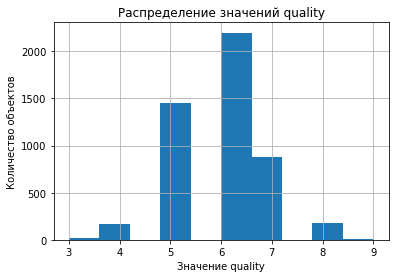

In [6]:
# Посмотрим распределение значений качества вина
data_original["quality"].hist()
plt.xlabel("Значение quality")
plt.ylabel("Количество объектов")
plt.title("Распределение значений quality")
plt.show()

In [7]:
# Также посмотрим это распределение в числах
data_original["quality"].value_counts()

6    2198
5    1457
7     880
8     175
4     163
3      20
9       5
Name: quality, dtype: int64

In [8]:
# Дисперсия качества вина
data_original["quality"].var()

0.7843556854710759

In [9]:
# Ассиметрия качества вина
((data_original["quality"] - data_original["quality"].mean()) ** 3).mean()

0.10815857002387506

In [10]:
# Эксцесс (островершинность) качества вина
((data_original["quality"] - data_original["quality"].mean()) ** 4).mean()

1.977154209615528

In [11]:
print("""
Всего у нас около 4900 строк данных - не так много. Сложные модели,
скорее всего, будут переобучаться. Оценка качества вина имеет распределение,
похожее на Гауссово - чаще всего встречаются средние значения 5 и 6,
также нередко и 7, но 6 - явный рекордсмен встречаемости. Остальные редки.
при дисперсии 0.78

Задачу можно поставить тремя способами.

- Регрессия - предсказать значение качества с метрикой R2 (коэффициент
  детерминации).
- Многоклассовая классификация - также предсказать точное значение качества, но уже
  как классификацию на 7 классов. При этом в качестве оценки качества модели
  будет использоваться верность, и можно исходить из того, что верность модели,
  всегда предсказывающей наибольший класс (качество 6) равна 45 процентов.
- Классификация на 3 класса - выбор между классами "качество <= 5", "качество=6" и
  "качество >= 7".
  В первом случае оценка будет почти наверняка 5, в третьем - почти наверняка 7.
  При оценке качества модели также используется верность и также исходя из верности
  "нулевой модели", не зависящей от признаков вообще, равной 45 процентов - столько
  получится, если всегда предсказывать среднее качество, равное 6
""")


Всего у нас около 4900 строк данных - не так много. Сложные модели,
скорее всего, будут переобучаться. Оценка качества вина имеет распределение,
похожее на Гауссово - чаще всего встречаются средние значения 5 и 6,
также нередко и 7, но 6 - явный рекордсмен встречаемости. Остальные редки.
при дисперсии 0.78

Задачу можно поставить тремя способами.

- Регрессия - предсказать значение качества с метрикой R2 (коэффициент
  детерминации).
- Многоклассовая классификация - также предсказать точное значение качества, но уже
  как классификацию на 7 классов. При этом в качестве оценки качества модели
  будет использоваться верность, и можно исходить из того, что верность модели,
  всегда предсказывающей наибольший класс (качество 6) равна 45 процентов.
- Классификация на 3 класса - выбор между классами "качество <= 5", "качество=6" и
  "качество >= 7".
  В первом случае оценка будет почти наверняка 5, в третьем - почти наверняка 7.
  При оценке качества модели также используется верность и так

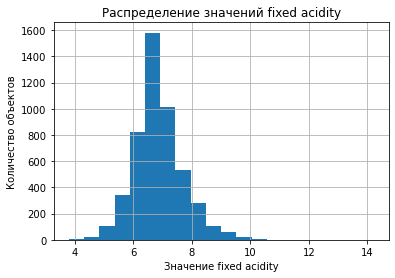

In [12]:
# Смотрим визуально распределение признаков вида, начиная с fixed acidity
data_original["fixed acidity"].hist(bins=20)
plt.xlabel("Значение fixed acidity")
plt.ylabel("Количество объектов")
plt.title("Распределение значений fixed acidity")
plt.show()

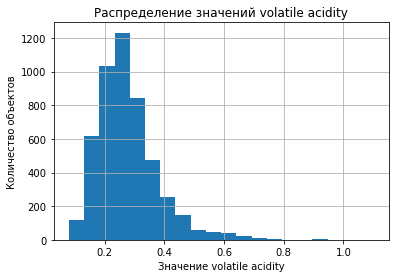

In [13]:
data_original["volatile acidity"].hist(bins=20)
plt.xlabel("Значение volatile acidity")
plt.ylabel("Количество объектов")
plt.title("Распределение значений volatile acidity")
plt.show()

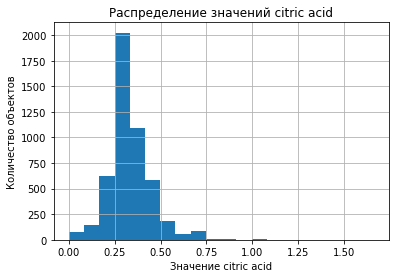

In [14]:
data_original["citric acid"].hist(bins=20)
plt.xlabel("Значение citric acid")
plt.ylabel("Количество объектов")
plt.title("Распределение значений citric acid")
plt.show()

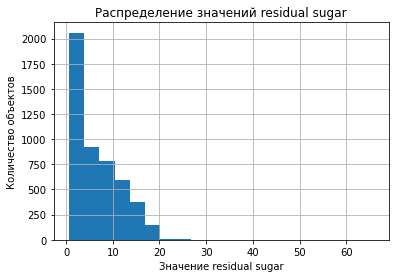

In [15]:
data_original["residual sugar"].hist(bins=20)
plt.xlabel("Значение residual sugar")
plt.ylabel("Количество объектов")
plt.title("Распределение значений residual sugar")
plt.show()

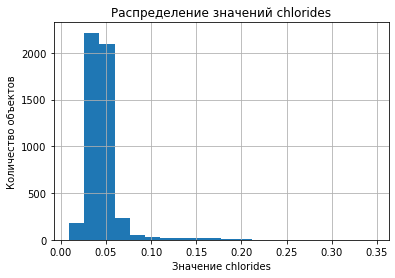

In [16]:
data_original["chlorides"].hist(bins=20)
plt.xlabel("Значение chlorides")
plt.ylabel("Количество объектов")
plt.title("Распределение значений chlorides")
plt.show()

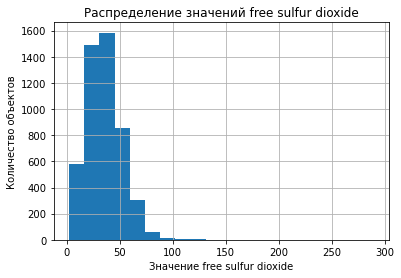

In [17]:
data_original["free sulfur dioxide"].hist(bins=20)
plt.xlabel("Значение free sulfur dioxide")
plt.ylabel("Количество объектов")
plt.title("Распределение значений free sulfur dioxide")
plt.show()

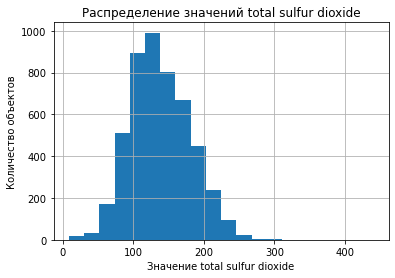

In [18]:
data_original["total sulfur dioxide"].hist(bins=20)
plt.xlabel("Значение total sulfur dioxide")
plt.ylabel("Количество объектов")
plt.title("Распределение значений total sulfur dioxide")
plt.show()

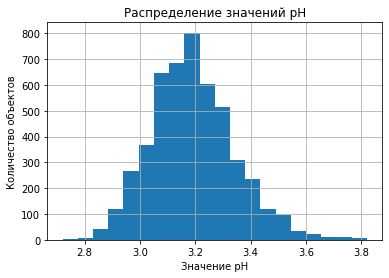

In [19]:
data_original["pH"].hist(bins=20)
plt.xlabel("Значение pH")
plt.ylabel("Количество объектов")
plt.title("Распределение значений pH")
plt.show()

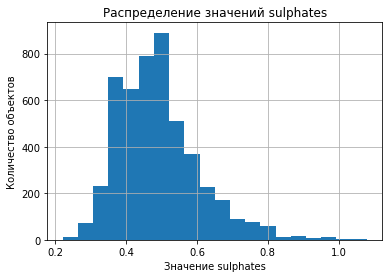

In [20]:
data_original["sulphates"].hist(bins=20)
plt.xlabel("Значение sulphates")
plt.ylabel("Количество объектов")
plt.title("Распределение значений sulphates")
plt.show()

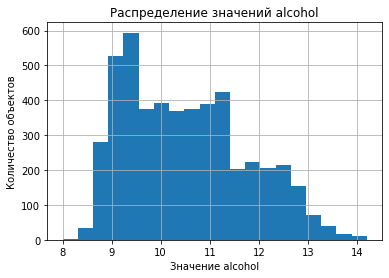

In [21]:
data_original["alcohol"].hist(bins=20)
plt.xlabel("Значение alcohol")
plt.ylabel("Количество объектов")
plt.title("Распределение значений alcohol")
plt.show()

In [22]:
print("""
Все признаки распределены непрерывно. Но если одни имеют вершину в районе центре распределения,
как и целевая переменная то другие - вершину ближе к левому краю. Возможно, качество линейных
моделей можно будет улучшить, применив к этим распределениям логарифмическое преобразование
""")


Все признаки распределены непрерывно. Но если одни имеют вершину в районе центре распределения,
как и целевая переменная то другие - вершину ближе к левому краю. Возможно, качество линейных
моделей можно будет улучшить, применив к этим распределениям логарифмическое преобразование



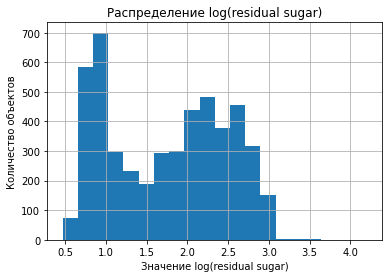

In [23]:
np.log1p(data_original["residual sugar"]).hist(bins=20)
plt.xlabel("Значение log(residual sugar)")
plt.ylabel("Количество объектов")
plt.title("Распределение log(residual sugar)")
plt.show()

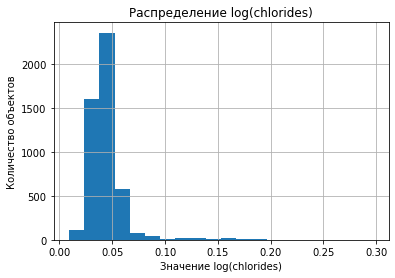

In [24]:
np.log1p(data_original["chlorides"]).hist(bins=20)
plt.xlabel("Значение log(chlorides)")
plt.ylabel("Количество объектов")
plt.title("Распределение log(chlorides)")
plt.show()

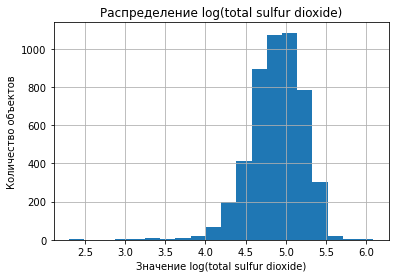

In [25]:
np.log1p(data_original["total sulfur dioxide"]).hist(bins=20)
plt.xlabel("Значение log(total sulfur dioxide)")
plt.ylabel("Количество объектов")
plt.title("Распределение log(total sulfur dioxide)")
plt.show()

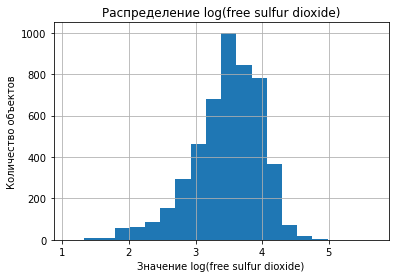

In [26]:
np.log1p(data_original["free sulfur dioxide"]).hist(bins=20)
plt.xlabel("Значение log(free sulfur dioxide)")
plt.ylabel("Количество объектов")
plt.title("Распределение log(free sulfur dioxide)")
plt.show()

In [27]:
print("""
Распределение логарифма residual sugar на нормальное уж точно не похоже, но
для остальных признаков вполне можно попробовать
""")


Распределение логарифма residual sugar на нормальное уж точно не похоже, но
для остальных признаков вполне можно попробовать



In [28]:
# Эти функции создают заготовки таблиц для сравнительного анализа
# качества моделей классификации и регрессии

def createRegressionScoreboard():
    """
    Создает пустую таблицу, индексированную разновидностями моделей
    регрессии и имеющую 3 столбца. Один из которых будет хранить
    строку с гиперпараметрами найденной лучшей модели этого класса,
    второй - значение коэффициента детерминации лучшей модели на
    обучающих данных, а третий - значение коэффициента детерминации
    для тесровых данных
    """
    return pd.DataFrame(
    {
        "best_model": "",
        "train_score": np.NaN,
        "test_score": np.NaN
    },
    index=[
        "Линейная регрессия",
        "Линейная регрессия с масштабированием",
        "Метод опорных векторов",
        "Метод опорных векторов с масштабированием",
        "Метод ближайших соседей",
        "Метод ближайших соседей с масштабированием",
        "Случайный лес",
        "Случайный лес с преобразованием главных компонент",
        "Градиентный бустинг"
    ]
)

def createClassificationScoreboard():
    """
    Создает пустую таблицу, индексированную разновидностями моделей
    классификации и имеющую 3 столбца. Один из которых будет хранить
    строку с гиперпараметрами найденной лучшей модели этого класса,
    второй - значение верности лучшей модели на обучающих данных, а
    третий - значение верности для тесровых данных
    """
    return pd.DataFrame(
    {
        "best_model": "",
        "train_score": np.NaN,
        "test_score": np.NaN
    },
    index=[
        "Линейная классификация",
        "Линейная классификация с масштабированием",
        "Метод опорных векторов",
        "Метод опорных векторов с масштабированием",
        "Метод ближайших соседей",
        "Метод ближайших соседей с масштабированием",
        "Случайный лес",
        "Случайный лес с преобразованием главных компонент",
        "Градиентный бустинг"
    ]
)


In [29]:
# Создаем таблицы для хранения результатов обучения. Первая таблица -
# для хранения результатов обучения моделей регрессии. Она будет индексирована
# названиями моделей, в столбцах - строка с найденными гиперпараметрами
# наилучшей модели, качество модели (коэффициент детерминации) на
# обучающих данных и качество на тестовых данных.
REGRESSION_SCOREBOARD = createRegressionScoreboard()

# Еще одна таблица для хранения результатов обучения, применяемая для
# матрицы признаков, в которой некоторый из исходных признаков заменены
# их логарифмами. Формат матрицы такой же, как и для первой матрицы.
LOG1P_REGRESSION_SCOREBOARD = createRegressionScoreboard()

# Еще одна таблица результатов, аналогичная первым двум. Она хранит
# данные о качестве моделей для многоклассовой классификации.
# Качеством модели является ее верность (accuracy)
CLASSIFICATION7_SCOREBOARD = createClassificationScoreboard()

# Еще одна таблица результатов, аналогичная первым двум. Она хранит
# данные о качестве моделей для классификации на 3 класса
CLASSIFICATION3_SCOREBOARD = createClassificationScoreboard()



In [30]:
# Функция, обучающие ряд моделей регресии и заносящая
# данные об их качестве в общую таблицу для удобного
# анализа

def fitRegressors(X_train, X_test, y_train, y_test, scoreboard):
    """
    Обучает различные модели регрессии на матрице признаков X_train
    со столбцом значений целевой переменной y_train, затем оценивает
    качество всех моделей на матрице признаков X_test со столбцом
    целевой переменной y_test. Заносит результаты в матрицу scoreboard,
    имеющую столбцы best_model, train_score и test_score - см. описание
    таблицы REGRESSION_SCOREBOARD.
    
    Все модели обучаются с выбором оптимальных гиперпараметров с помощью
    кросс-валидации. Заметим, что для модели линейной регрессии
    используется класс RidgeCV, имеющий встроенный перебор гиперпараметра
    регуляризации, поэтому в явном виде перебор гиперпараметров для
    него не делается.
    """
    # Пробуем линейную регрессию с регуляризацией. Подбор наилучшего гиперпараметра регуляризации
    # уже встроен в эту модель, так что в явном виде перебора не делаем
    reg = RidgeCV()
    reg.fit(X_train, y_train)
    # Выводим качество модели на обучающих и тестовых данных на экран
    print("Линейная (гребневая) регрессия")
    print("------------------------------")
    print(reg.score(X_train, y_train))
    print(reg.score(X_test, y_test))
    # Заносим результаты модели в таблицу результатов
    scoreboard.loc["Линейная регрессия", "best_model"] = str(reg).replace("\n", " ")
    scoreboard.loc["Линейная регрессия", "train_score"] = reg.score(X_train, y_train)
    scoreboard.loc["Линейная регрессия", "test_score"] = reg.score(X_test, y_test)
    # Пробуем снова линейную модель, но предварительно приведя все признаки к единому масштабу
    reg = Pipeline(
        [
            ('pre', StandardScaler()),
            ('reg', RidgeCV())
        ]
    )
    reg.fit(X_train, y_train)
    # Выводим качество модели на обучающих и тестовых данных на экран
    print("Линейная (гребневая) регрессия с масштабированием признаков")
    print("-----------------------------------------------------------")
    print(reg.score(X_train, y_train))
    print(reg.score(X_test, y_test))
    # Заносим результаты модели в таблицу результатов
    scoreboard.loc["Линейная регрессия с масштабированием", "best_model"] = str(reg).replace("\n", " ")
    scoreboard.loc["Линейная регрессия с масштабированием", "train_score"] = reg.score(X_train, y_train)
    scoreboard.loc["Линейная регрессия с масштабированием", "test_score"] = reg.score(X_test, y_test)
    # Пробуем метод опорных векторов, с перебором гиперпараметров и кросс-валидацией для
    # отбора лучших гиперпараметров
    reg = GridSearchCV(
        SVR(),
        {
            "gamma": ['scale', 0.001, 0.005, 0.01, 0.05, 0.1, 0.5],
            "C": [0.1, 1.0, 10.0]
        },
        cv=5
    )
    reg.fit(X_train, y_train)
    # Выводим качество модели на обучающих и тестовых данных на экран
    print("Метод опорных векторов")
    print("----------------------")
    print(reg.score(X_train, y_train))
    print(reg.score(X_test, y_test))
    # Заносим результаты модели в таблицу результатов
    scoreboard.loc["Метод опорных векторов", "best_model"] = str(reg.best_estimator_).replace("\n", " ")
    scoreboard.loc["Метод опорных векторов", "train_score"] = reg.score(X_train, y_train)
    scoreboard.loc["Метод опорных векторов", "test_score"] = reg.score(X_test, y_test)
    # Снова пробуем регрессию методом опорных векторов с подбором гиперпараметров, но теперь
    # предварительно приводим входные признаки к единому масштабу - нулевому среднему, единичной
    # дисперсии
    reg = GridSearchCV(
        Pipeline(
            [
                ('scale', StandardScaler()),
                ('reg', SVR())
            ]
        ),
        {
            "reg__gamma": ['scale', 0.001, 0.005, 0.01, 0.05, 0.1, 0.5],
            "reg__C": [0.1, 1.0, 10.0]
        },
        cv=5
    )
    reg.fit(X_train, y_train)
    # Выводим качество модели на обучающих и тестовых данных на экран
    print("Метод опорных векторов с масштабированием")
    print("-----------------------------------------")
    print(reg.score(X_train, y_train))
    print(reg.score(X_test, y_test))
    # Заносим результаты модели в таблицу результатов
    scoreboard.loc["Метод опорных векторов с масштабированием", "best_model"] = str(reg.best_estimator_).replace("\n", " ")
    scoreboard.loc["Метод опорных векторов с масштабированием", "train_score"] = reg.score(X_train, y_train)
    scoreboard.loc["Метод опорных векторов с масштабированием", "test_score"] = reg.score(X_test, y_test)
    # Обучаем регрессию на основе ближайших соседей, с автоматическим выбором
    # оптимального количества соседей
    reg = GridSearchCV(
        KNeighborsRegressor(),
        {
            "n_neighbors": [5, 15, 25, 35]
        },
        cv=5
    )
    reg.fit(X_train, y_train)
    # Выводим качество модели на обучающих и тестовых данных на экран
    print("Метод ближайших соседей")
    print("-----------------------")
    print(reg.score(X_train, y_train))
    print(reg.score(X_test, y_test))
    # Заносим результаты модели в таблицу результатов
    scoreboard.loc["Метод ближайших соседей", "best_model"] = str(reg.best_estimator_).replace("\n", " ")
    scoreboard.loc["Метод ближайших соседей", "train_score"] = reg.score(X_train, y_train)
    scoreboard.loc["Метод ближайших соседей", "test_score"] = reg.score(X_test, y_test)
    # Снова обучаем регрессию на основе ближайших соседей, но на этот раз
    # предварительно приводим все признаки к единому масштабу
    reg = GridSearchCV(
        Pipeline(
            [
                ('scale', StandardScaler()),
                ('reg', KNeighborsRegressor())
            ]
        ),
        {
            "reg__n_neighbors": [5, 15, 25, 35]
        },
        cv=5
    )
    reg.fit(X_train, y_train)
    print("Метод ближайших соседей с масштабированием")
    print("------------------------------------------")
    print(reg.score(X_train, y_train))
    print(reg.score(X_test, y_test))
    # Заносим результаты модели в таблицу результатов
    scoreboard.loc["Метод ближайших соседей с масштабированием", "best_model"] = str(reg.best_estimator_).replace("\n", " ")
    scoreboard.loc["Метод ближайших соседей с масштабированием", "train_score"] = reg.score(X_train, y_train)
    scoreboard.loc["Метод ближайших соседей с масштабированием", "test_score"] = reg.score(X_test, y_test)
    # Обучаем регрессию на основе случайного леса, выбрав оптимальную глубину
    # деревьев и их количество перебором с кросс-валидацией
    reg = GridSearchCV(
        ExtraTreesRegressor(random_state=0),
        {
            "max_depth": [3, 4, 5],
            "n_estimators": [50, 100, 200, 300]
        },
        cv=5
    )
    reg.fit(X_train, y_train)
    print("Случайный лес")
    print("-------------")
    print(reg.score(X_train, y_train))
    print(reg.score(X_test, y_test))
    # Заносим результаты модели в таблицу результатов
    scoreboard.loc["Случайный лес", "best_model"] = str(reg.best_estimator_).replace("\n", " ")
    scoreboard.loc["Случайный лес", "train_score"] = reg.score(X_train, y_train)
    scoreboard.loc["Случайный лес", "test_score"] = reg.score(X_test, y_test)
    if X_train.shape[1] >= 10:
        # Еще раз обучаем модель на основе случайного леса, но теперь предварительно
        # применяем к признакам преобразование главных компонент
        reg = GridSearchCV(
            Pipeline(
                [
                    ('pca', PCA()),
                    ('reg', ExtraTreesRegressor(random_state=0))
                ]
            ),
            {
                "pca__n_components": [3, 5, 7, 10],
                "reg__max_depth": [3, 4, 5],
                "reg__n_estimators": [50, 100, 200, 300]
            },
            cv=5
        )
    else:
        # Еще раз обучаем модель на основе случайного леса, но теперь предварительно
        # применяем к признакам преобразование главных компонент
        reg = GridSearchCV(
            Pipeline(
                [
                    ('pca', PCA()),
                    ('reg', ExtraTreesRegressor(random_state=0))
                ]
            ),
            {
                "reg__max_depth": [3, 4, 5],
                "reg__n_estimators": [50, 100, 200, 300]
            },
            cv=5
        )
    reg.fit(X_train, y_train)
    print("Случайный лес с преобразованием главных компонент")
    print("-------------------------------------------------")
    print(reg.score(X_train, y_train))
    print(reg.score(X_test, y_test))
    # Заносим результаты модели в таблицу результатов
    scoreboard.loc["Случайный лес с преобразованием главных компонент", "best_model"] = str(reg.best_estimator_).replace("\n", " ")
    scoreboard.loc["Случайный лес с преобразованием главных компонент", "train_score"] = reg.score(X_train, y_train)
    scoreboard.loc["Случайный лес с преобразованием главных компонент", "test_score"] = reg.score(X_test, y_test)
    # Обучаем регрессию на основе градиентного бустинга. Выбираем глубину
    # деревьев и их количество с кросс-валидацией
    reg = GridSearchCV(
        GradientBoostingRegressor(random_state=0),
        {
            "max_depth": [3, 4, 5],
            "n_estimators": [10, 25, 50, 75]
        },
        cv=5
    )
    reg.fit(X_train, y_train)
    print("Градиентный бустинг")
    print("-------------------")
    print(reg.score(X_train, y_train))
    print(reg.score(X_test, y_test))
    # Заносим результаты модели в таблицу результатов
    scoreboard.loc["Градиентный бустинг", "best_model"] = str(reg.best_estimator_).replace("\n", " ")
    scoreboard.loc["Градиентный бустинг", "train_score"] = reg.score(X_train, y_train)
    scoreboard.loc["Градиентный бустинг", "test_score"] = reg.score(X_test, y_test)

In [31]:
# Аналогичная функция, обучающая классификаторы

def fitClassifiers(X_train, X_test, y_train, y_test, scoreboard):
    """
    Обучает различные модели классификации на матрице признаков X_train
    со столбцом значений целевой переменной y_train, затем оценивает
    качество всех моделей на матрице признаков X_test со столбцом
    целевой переменной y_test. Заносит результаты в матрицу scoreboard,
    имеющую столбцы best_model, train_score и test_score - см. описание
    таблицы CLASSIFIER_SCOREBOARD.
    
    Все модели обучаются с выбором оптимальных гиперпараметров с помощью
    кросс-валидации. Заметим, что для модели линейной классификации
    используется класс RidgeClassifierCV, имеющий встроенный перебор гиперпараметра
    регуляризации, поэтому в явном виде перебор гиперпараметров для
    него не делается.
    """
    # Обучаем наивный байесовский классификатор
    clf = GaussianNB()
    clf.fit(X_train, y_train)
    print("Наивный байесовский классификатор")
    print("---------------------------------")
    print(clf.score(X_train, y_train))
    print(clf.score(X_test, y_test))
    # Заносим результаты модели в таблицу результатов
    scoreboard.loc["Наивный байесовский классификатор", "best_model"] = str(clf).replace("\n", " ")
    scoreboard.loc["Наивный байесовский классификатор", "train_score"] = clf.score(X_train, y_train)
    scoreboard.loc["Наивный байесовский классификатор", "test_score"] = clf.score(X_test, y_test)
    # Пробуем линейную классификацию с регуляризацией. Подбор наилучшего гиперпараметра регуляризации
    # уже встроен в эту модель, так что в явном виде перебора не делаем
    clf = RidgeClassifierCV()
    clf.fit(X_train, y_train)
    # Выводим качество модели на обучающих и тестовых данных на экран
    print("Линейная (гребневая) классификация")
    print("----------------------------------")
    print(clf.score(X_train, y_train))
    print(clf.score(X_test, y_test))
    # Заносим результаты модели в таблицу результатов
    scoreboard.loc["Линейная классификация", "best_model"] = str(clf).replace("\n", " ")
    scoreboard.loc["Линейная классификация", "train_score"] = clf.score(X_train, y_train)
    scoreboard.loc["Линейная классификация", "test_score"] = clf.score(X_test, y_test)
    # Пробуем снова линейную модель, но предварительно приведя все признаки к единому масштабу
    clf = Pipeline(
        [
            ('pre', StandardScaler()),
            ('clf', RidgeClassifierCV())
        ]
    )
    clf.fit(X_train, y_train)
    # Выводим качество модели на обучающих и тестовых данных на экран
    print("Линейная (гребневая) классификация с масштабированием признаков")
    print("---------------------------------------------------------------")
    print(clf.score(X_train, y_train))
    print(clf.score(X_test, y_test))
    # Заносим результаты модели в таблицу результатов
    scoreboard.loc["Линейная классификация с масштабированием", "best_model"] = str(clf).replace("\n", " ")
    scoreboard.loc["Линейная классификация с масштабированием", "train_score"] = clf.score(X_train, y_train)
    scoreboard.loc["Линейная классификация с масштабированием", "test_score"] = clf.score(X_test, y_test)
    # Пробуем метод опорных векторов, с перебором гиперпараметров и кросс-валидацией для
    # отбора лучших гиперпараметров
    clf = GridSearchCV(
        SVC(),
        {
            "gamma": ['scale', 0.001, 0.005, 0.01, 0.05, 0.1, 0.5],
            "C": [0.1, 1.0, 10.0]
        },
        cv=4
    )
    clf.fit(X_train, y_train)
    # Выводим качество модели на обучающих и тестовых данных на экран
    print("Метод опорных векторов")
    print("----------------------")
    print(clf.score(X_train, y_train))
    print(clf.score(X_test, y_test))
    # Заносим результаты модели в таблицу результатов
    scoreboard.loc["Метод опорных векторов", "best_model"] = str(clf.best_estimator_).replace("\n", " ")
    scoreboard.loc["Метод опорных векторов", "train_score"] = clf.score(X_train, y_train)
    scoreboard.loc["Метод опорных векторов", "test_score"] = clf.score(X_test, y_test)
    # Снова пробуем регрессию методом опорных векторов с подбором гиперпараметров, но теперь
    # предварительно приводим входные признаки к единому масштабу - нулевому среднему, единичной
    # дисперсии
    reg = GridSearchCV(
        Pipeline(
            [
                ('scale', StandardScaler()),
                ('reg', SVC())
            ]
        ),
        {
            "reg__gamma": ['scale', 0.001, 0.005, 0.01, 0.05, 0.1, 0.5],
            "reg__C": [0.1, 1.0, 10.0]
        },
        cv=4
    )
    reg.fit(X_train, y_train)
    # Выводим качество модели на обучающих и тестовых данных на экран
    print("Метод опорных векторов с масштабированием")
    print("-----------------------------------------")
    print(reg.score(X_train, y_train))
    print(reg.score(X_test, y_test))
    # Заносим результаты модели в таблицу результатов
    scoreboard.loc["Метод опорных векторов с масштабированием", "best_model"] = str(reg.best_estimator_).replace("\n", " ")
    scoreboard.loc["Метод опорных векторов с масштабированием", "train_score"] = reg.score(X_train, y_train)
    scoreboard.loc["Метод опорных векторов с масштабированием", "test_score"] = reg.score(X_test, y_test)
    # Обучаем регрессию на основе ближайших соседей, с автоматическим выбором
    # оптимального количества соседей
    reg = GridSearchCV(
        KNeighborsClassifier(),
        {
            "n_neighbors": [5, 15, 25, 35]
        },
        cv=4
    )
    reg.fit(X_train, y_train)
    # Выводим качество модели на обучающих и тестовых данных на экран
    print("Метод ближайших соседей")
    print("-----------------------")
    print(reg.score(X_train, y_train))
    print(reg.score(X_test, y_test))
    # Заносим результаты модели в таблицу результатов
    scoreboard.loc["Метод ближайших соседей", "best_model"] = str(reg.best_estimator_).replace("\n", " ")
    scoreboard.loc["Метод ближайших соседей", "train_score"] = reg.score(X_train, y_train)
    scoreboard.loc["Метод ближайших соседей", "test_score"] = reg.score(X_test, y_test)
    # Снова обучаем регрессию на основе ближайших соседей, но на этот раз
    # предварительно приводим все признаки к единому масштабу
    reg = GridSearchCV(
        Pipeline(
            [
                ('scale', StandardScaler()),
                ('reg', KNeighborsClassifier())
            ]
        ),
        {
            "reg__n_neighbors": [5, 15, 25, 35]
        },
        cv=4
    )
    reg.fit(X_train, y_train)
    print("Метод ближайших соседей с масштабированием")
    print("------------------------------------------")
    print(reg.score(X_train, y_train))
    print(reg.score(X_test, y_test))
    # Заносим результаты модели в таблицу результатов
    scoreboard.loc["Метод ближайших соседей с масштабированием", "best_model"] = str(reg.best_estimator_).replace("\n", " ")
    scoreboard.loc["Метод ближайших соседей с масштабированием", "train_score"] = reg.score(X_train, y_train)
    scoreboard.loc["Метод ближайших соседей с масштабированием", "test_score"] = reg.score(X_test, y_test)
    # Обучаем регрессию на основе случайного леса, выбрав оптимальную глубину
    # деревьев и их количество перебором с кросс-валидацией
    reg = GridSearchCV(
        ExtraTreesClassifier(random_state=0),
        {
            "max_depth": [3, 4, 5],
            "n_estimators": [50, 100, 200, 300]
        },
        cv=4
    )
    reg.fit(X_train, y_train)
    print("Случайный лес")
    print("-------------")
    print(reg.score(X_train, y_train))
    print(reg.score(X_test, y_test))
    # Заносим результаты модели в таблицу результатов
    scoreboard.loc["Случайный лес", "best_model"] = str(reg.best_estimator_).replace("\n", " ")
    scoreboard.loc["Случайный лес", "train_score"] = reg.score(X_train, y_train)
    scoreboard.loc["Случайный лес", "test_score"] = reg.score(X_test, y_test)
    if X_train.shape[1] >= 10:
        # Еще раз обучаем модель на основе случайного леса, но теперь предварительно
        # применяем к признакам преобразование главных компонент
        clf = GridSearchCV(
            Pipeline(
                [
                    ('pca', PCA()),
                    ('clf', ExtraTreesClassifier(random_state=0))
                ]
            ),
            {
                "pca__n_components": [3, 5, 7, 10],
                "clf__max_depth": [3, 4, 5],
                "clf__n_estimators": [50, 100, 200, 300]
            },
            cv=4
        )
    else:
        clf = GridSearchCV(
            Pipeline(
                [
                    ('pca', PCA()),
                    ('clf', ExtraTreesClassifier(random_state=0))
                ]
            ),
            {
                "clf__max_depth": [3, 4, 5],
                "clf__n_estimators": [50, 100, 200, 300]
            },
            cv=4
        )
    clf.fit(X_train, y_train)
    print("Случайный лес с преобразованием главных компонент")
    print("-------------------------------------------------")
    print(clf.score(X_train, y_train))
    print(clf.score(X_test, y_test))
    # Заносим результаты модели в таблицу результатов
    scoreboard.loc["Случайный лес с преобразованием главных компонент", "best_model"] = str(clf.best_estimator_).replace("\n", " ")
    scoreboard.loc["Случайный лес с преобразованием главных компонент", "train_score"] = clf.score(X_train, y_train)
    scoreboard.loc["Случайный лес с преобразованием главных компонент", "test_score"] = clf.score(X_test, y_test)
    # Обучаем регрессию на основе градиентного бустинга. Выбираем глубину
    # деревьев и их количество с кросс-валидацией
    clf = GridSearchCV(
        GradientBoostingClassifier(random_state=0),
        {
            "max_depth": [3, 4, 5],
            "n_estimators": [10, 25, 50, 75]
        },
        cv=4
    )
    clf.fit(X_train, y_train)
    print("Градиентный бустинг")
    print("-------------------")
    print(clf.score(X_train, y_train))
    print(clf.score(X_test, y_test))
    # Заносим результаты модели в таблицу результатов
    scoreboard.loc["Градиентный бустинг", "best_model"] = str(clf.best_estimator_).replace("\n", " ")
    scoreboard.loc["Градиентный бустинг", "train_score"] = clf.score(X_train, y_train)
    scoreboard.loc["Градиентный бустинг", "test_score"] = clf.score(X_test, y_test)

In [32]:
# Копируем данные перед обучением моделей, так как в процессе обучения
# значения качества и признаков иногда будут меняться
data = data_original.copy()

In [33]:
# Выделяем матрицу признаков и столбец целевых переменных, делим данные на обучающие и тестовые
X = data.drop("quality", axis='columns').values
y = data.quality.values
(X_train, X_test, y_train, y_test) = train_test_split(X, y, random_state=0, stratify=y)

In [34]:
# Обучаем ряд моделей регрессии и смотрим их результаты
fitRegressors(X_train, X_test, y_train, y_test, REGRESSION_SCOREBOARD)

Линейная (гребневая) регрессия
------------------------------
0.26761091750915333
0.2855913071019549
Линейная (гребневая) регрессия с масштабированием признаков
-----------------------------------------------------------
0.2756148749138332
0.2963657144038928
Метод опорных векторов
----------------------
0.3212991697205262
0.27993766023975664
Метод опорных векторов с масштабированием
-----------------------------------------
0.8024661454101931
0.44242093038364794
Метод ближайших соседей
-----------------------
0.21558291605658153
0.16373666794266517
Метод ближайших соседей с масштабированием
------------------------------------------
0.3874985836452105
0.35990173110458934
Случайный лес
-------------
0.33122577942984044
0.3258768143373071
Случайный лес с преобразованием главных компонент
-------------------------------------------------
0.2951930791686662
0.2897376553992239
Градиентный бустинг
-------------------
0.640397597723983
0.45444177049745993


In [35]:
# Еще раз смотрим результаты регрессионных моделей, в виде таблицы
# При этом не отображаем тип модели, так как он понятен из столбца best_model
# Так для описания лучшей модели и ее гиперпараметров остается больше
# места
REGRESSION_SCOREBOARD.reset_index(drop=True).sort_values('test_score')

,best_model,train_score,test_score
4,KNeighborsRegressor(n_neighbors=25),0.215583,0.163737
2,"SVR(C=10.0, gamma=0.001)",0.321299,0.279938
0,"RidgeCV(alphas=array([ 0.1, 1. , 10. ]))",0.267611,0.285591
7,"Pipeline(steps=[('pca', PCA(n_components=10)), ('reg', ExtraTreesRegressor(max_depth=5, n_estimators=50, random_state=0))])",0.295193,0.289738
1,"Pipeline(steps=[('pre', StandardScaler()), ('reg', RidgeCV(alphas=array([ 0.1, 1. , 10. ])))])",0.275615,0.296366
6,"ExtraTreesRegressor(max_depth=5, n_estimators=300, random_state=0)",0.331226,0.325877
5,"Pipeline(steps=[('scale', StandardScaler()), ('reg', KNeighborsRegressor(n_neighbors=25))])",0.387499,0.359902
3,"Pipeline(steps=[('scale', StandardScaler()), ('reg', SVR(gamma=0.5))])",0.802466,0.442421
8,"GradientBoostingRegressor(max_depth=5, n_estimators=75, random_state=0)",0.640398,0.454442


In [36]:
# Делаем копию исходных данных
data = data_original.copy()
# И заменяем некоторые из признаков на их логарифмы
data["total sulfur dioxide"] = np.log1p(data["total sulfur dioxide"])
data["free sulfur dioxide"] = np.log1p(data["free sulfur dioxide"])
#data["residual sugar"] = np.log1p(data["residual sugar"])
data["chlorides"] = np.log1p(data["chlorides"])

In [37]:
# Выделяем матрицу признаков и столбец целевых переменных, делим данные на обучающие и тестовые
X = data.drop("quality", axis='columns').values
y = data.quality.values
(X_train, X_test, y_train, y_test) = train_test_split(X, y, random_state=0, stratify=y)

In [38]:
# Обучаем ряд моделей регрессии и смотрим их результаты
fitRegressors(X_train, X_test, y_train, y_test, LOG1P_REGRESSION_SCOREBOARD)

Линейная (гребневая) регрессия
------------------------------
0.2852099655445848
0.2942989350392148
Линейная (гребневая) регрессия с масштабированием признаков
-----------------------------------------------------------
0.29159479990288883
0.30452832776361594
Метод опорных векторов
----------------------
0.5050098240729619
0.3743285542985555
Метод опорных векторов с масштабированием
-----------------------------------------
0.8103986154532373
0.43507185761686185
Метод ближайших соседей
-----------------------
0.3886244729289381
0.3231576708774616
Метод ближайших соседей с масштабированием
------------------------------------------
0.43794999834958925
0.3720143289902126
Случайный лес
-------------
0.3376017661342894
0.3256828214387574
Случайный лес с преобразованием главных компонент
-------------------------------------------------
0.31536317612580667
0.2973060501793351
Градиентный бустинг
-------------------
0.640397597723983
0.454586561893644


In [39]:
# Еще раз смотрим результаты регрессионных моделей, в виде таблицы
LOG1P_REGRESSION_SCOREBOARD.reset_index(drop=True).sort_values('test_score')

,best_model,train_score,test_score
0,"RidgeCV(alphas=array([ 0.1, 1. , 10. ]))",0.285210,0.294299
7,"Pipeline(steps=[('pca', PCA(n_components=10)), ('reg', ExtraTreesRegressor(max_depth=5, random_state=0))])",0.315363,0.297306
1,"Pipeline(steps=[('pre', StandardScaler()), ('reg', RidgeCV(alphas=array([ 0.1, 1. , 10. ])))])",0.291595,0.304528
4,KNeighborsRegressor(n_neighbors=15),0.388624,0.323158
6,"ExtraTreesRegressor(max_depth=5, random_state=0)",0.337602,0.325683
5,"Pipeline(steps=[('scale', StandardScaler()), ('reg', KNeighborsRegressor(n_neighbors=15))])",0.437950,0.372014
2,SVR(gamma=0.5),0.505010,0.374329
3,"Pipeline(steps=[('scale', StandardScaler()), ('reg', SVR(gamma=0.5))])",0.810399,0.435072
8,"GradientBoostingRegressor(max_depth=5, n_estimators=75, random_state=0)",0.640398,0.454587


In [40]:
print("""
Пробуем решать задачу как задачу классификации
""")


Пробуем решать задачу как задачу классификации



In [41]:
# Возвращаемся к исходным данным, устранив логарифмическое преобразование признаков
data = data_original.copy()
data["quality"].value_counts()

6    2198
5    1457
7     880
8     175
4     163
3      20
9       5
Name: quality, dtype: int64

In [42]:
# Выделяем матрицу признаков и столбец целевых переменных, делим данные на обучающие и тестовые
X = data.drop("quality", axis='columns').values
y = data.quality.values
(X_train, X_test, y_train, y_test) = train_test_split(X, y, random_state=0, stratify=y)

In [43]:
# Обучаем ряд моделей классификации и смотрим результаты
fitClassifiers(X_train, X_test, y_train, y_test, CLASSIFICATION7_SCOREBOARD)

Наивный байесовский классификатор
---------------------------------
0.4511298665940648
0.4424489795918367
Линейная (гребневая) классификация
----------------------------------
0.5270895725564934
0.5273469387755102
Линейная (гребневая) классификация с масштабированием признаков
---------------------------------------------------------------
0.5284508576095834
0.5240816326530612
Метод опорных векторов
----------------------
0.9814865232779744
0.6097959183673469
Метод опорных векторов с масштабированием
-----------------------------------------
0.9899264906071331
0.6244897959183674
Метод ближайших соседей
-----------------------
0.49959161448407297
0.4555102040816327
Метод ближайших соседей с масштабированием
------------------------------------------
0.5951538252109991
0.5257142857142857
Случайный лес
-------------
0.5360740539068881
0.5093877551020408
Случайный лес с преобразованием главных компонент
-------------------------------------------------
0.488156820038116
0.476734693877551
Г

In [44]:
# Еще раз смотрим результаты классификации в виде таблицы
CLASSIFICATION7_SCOREBOARD.reset_index(drop=True).sort_values('test_score')

,best_model,train_score,test_score
9,GaussianNB(),0.451130,0.442449
4,KNeighborsClassifier(n_neighbors=35),0.499592,0.455510
7,"Pipeline(steps=[('pca', PCA(n_components=10)), ('clf', ExtraTreesClassifier(max_depth=5, n_estimators=300, random_state=0))])",0.488157,0.476735
6,"ExtraTreesClassifier(max_depth=5, n_estimators=50, random_state=0)",0.536074,0.509388
1,"Pipeline(steps=[('pre', StandardScaler()), ('clf', RidgeClassifierCV(alphas=array([ 0.1, 1. , 10. ])))])",0.528451,0.524082
5,"Pipeline(steps=[('scale', StandardScaler()), ('reg', KNeighborsClassifier(n_neighbors=15))])",0.595154,0.525714
0,"RidgeClassifierCV(alphas=array([ 0.1, 1. , 10. ]))",0.527090,0.527347
2,SVC(gamma=0.5),0.981487,0.609796
3,"Pipeline(steps=[('scale', StandardScaler()), ('reg', SVC(C=10.0, gamma=0.5))])",0.989926,0.624490
8,"GradientBoostingClassifier(max_depth=5, n_estimators=75, random_state=0)",0.899265,0.636735


In [45]:
print("""
Решаем задачу классификации на три класса
=========================================

Исходные данные делятся на три больших группы - качество 5 и менее, качество 6 и
качество 7 и более.""")


Решаем задачу классификации на три класса

Исходные данные делятся на три больших группы - качество 5 и менее, качество 6 и
качество 7 и более.


In [46]:
# Делаем копию исходных данных
data = data_original.copy()
# И заменяем метку качества на 3 возможных варианта - плохое, среднее, хорошее
data.loc[data["quality"] <= 5, "quality"] = 0
data.loc[data["quality"] == 6, "quality"] = 1
data.loc[data["quality"] >= 7, "quality"] = 2
data["quality"].value_counts()

1    2198
0    1640
2    1060
Name: quality, dtype: int64

In [47]:
# Выделяем матрицу признаков и столбец целевых переменных, делим данные на обучающие и тестовые
X = data.drop("quality", axis='columns').values
y = data.quality.values
(X_train, X_test, y_train, y_test) = train_test_split(X, y, random_state=0, stratify=y)

In [48]:
# Обучаем ряд моделей классификации и смотрим результаты
fitClassifiers(X_train, X_test, y_train, y_test, CLASSIFICATION3_SCOREBOARD)

Наивный байесовский классификатор
---------------------------------
0.5034032126327252
0.49551020408163265
Линейная (гребневая) классификация
----------------------------------
0.5624829839368364
0.5820408163265306
Линейная (гребневая) классификация с масштабированием признаков
---------------------------------------------------------------
0.5630274979580724
0.5795918367346938
Метод опорных векторов
----------------------
0.9907432616389872
0.5893877551020408
Метод опорных векторов с масштабированием
-----------------------------------------
0.9907432616389872
0.6555102040816326
Метод ближайших соседей
-----------------------
0.6898992649060713
0.5085714285714286
Метод ближайших соседей с масштабированием
------------------------------------------
0.6289136945276341
0.5910204081632653
Случайный лес
-------------
0.5829022597331881
0.5591836734693878
Случайный лес с преобразованием главных компонент
-------------------------------------------------
0.5387966240130684
0.5208163265306123

In [49]:
# Еще раз смотрим результаты классификации в виде таблицы
CLASSIFICATION3_SCOREBOARD.reset_index(drop=True).sort_values('test_score')

,best_model,train_score,test_score
9,GaussianNB(),0.503403,0.495510
4,KNeighborsClassifier(),0.689899,0.508571
7,"Pipeline(steps=[('pca', PCA(n_components=10)), ('clf', ExtraTreesClassifier(max_depth=5, n_estimators=50, random_state=0))])",0.538797,0.520816
6,"ExtraTreesClassifier(max_depth=5, random_state=0)",0.582902,0.559184
1,"Pipeline(steps=[('pre', StandardScaler()), ('clf', RidgeClassifierCV(alphas=array([ 0.1, 1. , 10. ])))])",0.563027,0.579592
0,"RidgeClassifierCV(alphas=array([ 0.1, 1. , 10. ]))",0.562483,0.582041
2,SVC(gamma=0.5),0.990743,0.589388
5,"Pipeline(steps=[('scale', StandardScaler()), ('reg', KNeighborsClassifier(n_neighbors=35))])",0.628914,0.591020
3,"Pipeline(steps=[('scale', StandardScaler()), ('reg', SVC(C=10.0, gamma=0.5))])",0.990743,0.655510
8,"GradientBoostingClassifier(max_depth=5, n_estimators=75, random_state=0)",0.869589,0.682449


In [50]:
# Обучаем еще раз модель, которая оказался лучшей
# Посмотрим, что будет если отобрать только самые важные для этой модели признаки
# Сначала возвращаемся к исходным данным
data = data_original.copy()
# Выделяем матрицу признаков и столбец целевых переменных, делим данные на обучающие и тестовые
X = data.drop("quality", axis='columns').values
y = data.quality.values
(X_train, X_test, y_train, y_test) = train_test_split(X, y, random_state=0, stratify=y)
# Обучаем модель
reg = ExtraTreesRegressor(max_depth=5, n_estimators=100, random_state=0)
reg.fit(X_train, y_train)
print(reg.score(X_train, y_train))
print(reg.score(X_test, y_test))

0.3291828202724755
0.3247875187576794


In [51]:
# Смотрим, какие признаки классификатор считает наиболее важными
pd.Series(reg.feature_importances_, index=data.drop('quality', axis='columns').columns)

fixed acidity           0.010160
volatile acidity        0.155223
citric acid             0.025320
residual sugar          0.012630
chlorides               0.031896
free sulfur dioxide     0.086152
total sulfur dioxide    0.028227
density                 0.045817
pH                      0.009071
sulphates               0.009087
alcohol                 0.586417
dtype: float64

In [52]:
print("""
Из всех признаков 2 выделяются как наиболее важные - это alcohol и
volatile acidity. Далее идет потом free sulfur dioxide, затем density
""")


Из всех признаков 2 выделяются как наиболее важные - это alcohol и
volatile acidity. Далее идет потом free sulfur dioxide, затем density



In [53]:
# Создаем копию исходных данных
data = data_original.copy()
# И разделяем данные на 3 класса - плохие, средние и хорошие вина
data.loc[data["quality"] <= 5, "quality"] = 0
data.loc[data["quality"] == 6, "quality"] = 1
data.loc[data["quality"] >= 7, "quality"] = 2
data["quality"].value_counts()

1    2198
0    1640
2    1060
Name: quality, dtype: int64

In [54]:
# Оставляем только 3 признака, отделяем столбец целевой переменной, делим данные
# на обучающие и тестовые
X = data[[
    'alcohol', 'volatile acidity', 'free sulfur dioxide'
]].values
y = data.quality.values
(X_train, X_test, y_train, y_test) = train_test_split(X, y, random_state=0, stratify=y)

In [55]:
# Создаем новую таблицу для сравнения качества классификаторов уже на этих данных 
X3_CLASSIFICATION_SCOREBOARD = createClassificationScoreboard()

In [56]:
# Обучаем ряд моделей классификации и смотрим результаты
fitClassifiers(X_train, X_test, y_train, y_test, X3_CLASSIFICATION_SCOREBOARD)

Наивный байесовский классификатор
---------------------------------
0.5494146474271713
0.5510204081632653
Линейная (гребневая) классификация
----------------------------------
0.5559488156820038
0.5616326530612245
Линейная (гребневая) классификация с масштабированием признаков
---------------------------------------------------------------
0.5562210726926219
0.5624489795918367
Метод опорных векторов
----------------------
0.5573101007350939
0.5395918367346939
Метод опорных векторов с масштабированием
-----------------------------------------
0.6123060168799347
0.5959183673469388
Метод ближайших соседей
-----------------------
0.697250204192758
0.5289795918367347
Метод ближайших соседей с масштабированием
------------------------------------------
0.6188401851347672
0.5942857142857143
Случайный лес
-------------
0.5635720119793085
0.5493877551020409
Случайный лес с преобразованием главных компонент
-------------------------------------------------
0.5679281241491968
0.5395918367346939
Г

In [57]:
X3_CLASSIFICATION_SCOREBOARD.reset_index(drop=True).sort_values('test_score')

,best_model,train_score,test_score
4,KNeighborsClassifier(),0.697250,0.528980
2,"SVC(C=10.0, gamma=0.01)",0.557310,0.539592
7,"Pipeline(steps=[('pca', PCA()), ('clf', ExtraTreesClassifier(max_depth=5, n_estimators=200, random_state=0))])",0.567928,0.539592
6,"ExtraTreesClassifier(max_depth=5, n_estimators=50, random_state=0)",0.563572,0.549388
9,GaussianNB(),0.549415,0.551020
0,"RidgeClassifierCV(alphas=array([ 0.1, 1. , 10. ]))",0.555949,0.561633
1,"Pipeline(steps=[('pre', StandardScaler()), ('clf', RidgeClassifierCV(alphas=array([ 0.1, 1. , 10. ])))])",0.556221,0.562449
5,"Pipeline(steps=[('scale', StandardScaler()), ('reg', KNeighborsClassifier(n_neighbors=25))])",0.618840,0.594286
3,"Pipeline(steps=[('scale', StandardScaler()), ('reg', SVC(C=10.0, gamma=0.5))])",0.612306,0.595918
8,"GradientBoostingClassifier(max_depth=5, n_estimators=75, random_state=0)",0.747073,0.621224


In [58]:
# Возвращаемся к исходным данным, с исходными значениями качества
data = data_original.copy()

In [59]:
# Оставляем только 3 признака, отделяем столбец целевой переменной, делим данные
# на обучающие и тестовые
X = data[[
    'alcohol', 'volatile acidity', 'free sulfur dioxide'
]].values
y = data.quality.values
(X_train, X_test, y_train, y_test) = train_test_split(X, y, random_state=0, stratify=y)

In [60]:
X3_REGRESSION_SCOREBOARD = createRegressionScoreboard()

In [61]:
# Обучаем ряд моделей регрессии и смотрим результаты
fitRegressors(X_train, X_test, y_train, y_test, X3_REGRESSION_SCOREBOARD)

Линейная (гребневая) регрессия
------------------------------
0.2462940143895762
0.2639355829496831
Линейная (гребневая) регрессия с масштабированием признаков
-----------------------------------------------------------
0.24629191766678482
0.2638982452849642
Метод опорных векторов
----------------------
0.2907872317530077
0.2823911028857028
Метод опорных векторов с масштабированием
-----------------------------------------
0.3199687106002599
0.3226651313049438
Метод ближайших соседей
-----------------------
0.3356108703527183
0.269104579889319
Метод ближайших соседей с масштабированием
------------------------------------------
0.40856415230578336
0.36085265053237503
Случайный лес
-------------
0.3109507758086957
0.3101359080678565
Случайный лес с преобразованием главных компонент
-------------------------------------------------
0.3052650173098006
0.31042192496110377
Градиентный бустинг
-------------------
0.4472869844936186
0.3637783572303789


In [62]:
# Показываем таблицу с результатами по разным моделям.
X3_REGRESSION_SCOREBOARD.reset_index(drop=True).sort_values('test_score')

,best_model,train_score,test_score
1,"Pipeline(steps=[('pre', StandardScaler()), ('reg', RidgeCV(alphas=array([ 0.1, 1. , 10. ])))])",0.246292,0.263898
0,"RidgeCV(alphas=array([ 0.1, 1. , 10. ]))",0.246294,0.263936
4,KNeighborsRegressor(n_neighbors=15),0.335611,0.269105
2,"SVR(C=10.0, gamma=0.005)",0.290787,0.282391
6,"ExtraTreesRegressor(max_depth=5, n_estimators=50, random_state=0)",0.310951,0.310136
7,"Pipeline(steps=[('pca', PCA()), ('reg', ExtraTreesRegressor(max_depth=5, n_estimators=300, random_state=0))])",0.305265,0.310422
3,"Pipeline(steps=[('scale', StandardScaler()), ('reg', SVR(C=10.0, gamma=0.05))])",0.319969,0.322665
5,"Pipeline(steps=[('scale', StandardScaler()), ('reg', KNeighborsRegressor(n_neighbors=15))])",0.408564,0.360853
8,"GradientBoostingRegressor(max_depth=4, n_estimators=75, random_state=0)",0.447287,0.363778


In [63]:
# Еще раз выводим на экран все результаты
# Это для регрессии по всем признакам
REGRESSION_SCOREBOARD.reset_index(drop=True).sort_values('test_score')

,best_model,train_score,test_score
4,KNeighborsRegressor(n_neighbors=25),0.215583,0.163737
2,"SVR(C=10.0, gamma=0.001)",0.321299,0.279938
0,"RidgeCV(alphas=array([ 0.1, 1. , 10. ]))",0.267611,0.285591
7,"Pipeline(steps=[('pca', PCA(n_components=10)), ('reg', ExtraTreesRegressor(max_depth=5, n_estimators=50, random_state=0))])",0.295193,0.289738
1,"Pipeline(steps=[('pre', StandardScaler()), ('reg', RidgeCV(alphas=array([ 0.1, 1. , 10. ])))])",0.275615,0.296366
6,"ExtraTreesRegressor(max_depth=5, n_estimators=300, random_state=0)",0.331226,0.325877
5,"Pipeline(steps=[('scale', StandardScaler()), ('reg', KNeighborsRegressor(n_neighbors=25))])",0.387499,0.359902
3,"Pipeline(steps=[('scale', StandardScaler()), ('reg', SVR(gamma=0.5))])",0.802466,0.442421
8,"GradientBoostingRegressor(max_depth=5, n_estimators=75, random_state=0)",0.640398,0.454442


In [64]:
# Это для регрессии, с заменой некоторых признаков на их логагифмы
LOG1P_REGRESSION_SCOREBOARD.reset_index(drop=True).sort_values('test_score')

,best_model,train_score,test_score
0,"RidgeCV(alphas=array([ 0.1, 1. , 10. ]))",0.285210,0.294299
7,"Pipeline(steps=[('pca', PCA(n_components=10)), ('reg', ExtraTreesRegressor(max_depth=5, random_state=0))])",0.315363,0.297306
1,"Pipeline(steps=[('pre', StandardScaler()), ('reg', RidgeCV(alphas=array([ 0.1, 1. , 10. ])))])",0.291595,0.304528
4,KNeighborsRegressor(n_neighbors=15),0.388624,0.323158
6,"ExtraTreesRegressor(max_depth=5, random_state=0)",0.337602,0.325683
5,"Pipeline(steps=[('scale', StandardScaler()), ('reg', KNeighborsRegressor(n_neighbors=15))])",0.437950,0.372014
2,SVR(gamma=0.5),0.505010,0.374329
3,"Pipeline(steps=[('scale', StandardScaler()), ('reg', SVR(gamma=0.5))])",0.810399,0.435072
8,"GradientBoostingRegressor(max_depth=5, n_estimators=75, random_state=0)",0.640398,0.454587


In [65]:
# Для регрессии по трем наиболее важным признакам
X3_REGRESSION_SCOREBOARD.reset_index(drop=True).sort_values('test_score')

,best_model,train_score,test_score
1,"Pipeline(steps=[('pre', StandardScaler()), ('reg', RidgeCV(alphas=array([ 0.1, 1. , 10. ])))])",0.246292,0.263898
0,"RidgeCV(alphas=array([ 0.1, 1. , 10. ]))",0.246294,0.263936
4,KNeighborsRegressor(n_neighbors=15),0.335611,0.269105
2,"SVR(C=10.0, gamma=0.005)",0.290787,0.282391
6,"ExtraTreesRegressor(max_depth=5, n_estimators=50, random_state=0)",0.310951,0.310136
7,"Pipeline(steps=[('pca', PCA()), ('reg', ExtraTreesRegressor(max_depth=5, n_estimators=300, random_state=0))])",0.305265,0.310422
3,"Pipeline(steps=[('scale', StandardScaler()), ('reg', SVR(C=10.0, gamma=0.05))])",0.319969,0.322665
5,"Pipeline(steps=[('scale', StandardScaler()), ('reg', KNeighborsRegressor(n_neighbors=15))])",0.408564,0.360853
8,"GradientBoostingRegressor(max_depth=4, n_estimators=75, random_state=0)",0.447287,0.363778


In [66]:
# Классификация на 7 классов
CLASSIFICATION7_SCOREBOARD.reset_index(drop=True).sort_values('test_score')

,best_model,train_score,test_score
9,GaussianNB(),0.451130,0.442449
4,KNeighborsClassifier(n_neighbors=35),0.499592,0.455510
7,"Pipeline(steps=[('pca', PCA(n_components=10)), ('clf', ExtraTreesClassifier(max_depth=5, n_estimators=300, random_state=0))])",0.488157,0.476735
6,"ExtraTreesClassifier(max_depth=5, n_estimators=50, random_state=0)",0.536074,0.509388
1,"Pipeline(steps=[('pre', StandardScaler()), ('clf', RidgeClassifierCV(alphas=array([ 0.1, 1. , 10. ])))])",0.528451,0.524082
5,"Pipeline(steps=[('scale', StandardScaler()), ('reg', KNeighborsClassifier(n_neighbors=15))])",0.595154,0.525714
0,"RidgeClassifierCV(alphas=array([ 0.1, 1. , 10. ]))",0.527090,0.527347
2,SVC(gamma=0.5),0.981487,0.609796
3,"Pipeline(steps=[('scale', StandardScaler()), ('reg', SVC(C=10.0, gamma=0.5))])",0.989926,0.624490
8,"GradientBoostingClassifier(max_depth=5, n_estimators=75, random_state=0)",0.899265,0.636735


In [67]:
# Классификация на 3 класса
CLASSIFICATION3_SCOREBOARD.reset_index(drop=True).sort_values('test_score')

,best_model,train_score,test_score
9,GaussianNB(),0.503403,0.495510
4,KNeighborsClassifier(),0.689899,0.508571
7,"Pipeline(steps=[('pca', PCA(n_components=10)), ('clf', ExtraTreesClassifier(max_depth=5, n_estimators=50, random_state=0))])",0.538797,0.520816
6,"ExtraTreesClassifier(max_depth=5, random_state=0)",0.582902,0.559184
1,"Pipeline(steps=[('pre', StandardScaler()), ('clf', RidgeClassifierCV(alphas=array([ 0.1, 1. , 10. ])))])",0.563027,0.579592
0,"RidgeClassifierCV(alphas=array([ 0.1, 1. , 10. ]))",0.562483,0.582041
2,SVC(gamma=0.5),0.990743,0.589388
5,"Pipeline(steps=[('scale', StandardScaler()), ('reg', KNeighborsClassifier(n_neighbors=35))])",0.628914,0.591020
3,"Pipeline(steps=[('scale', StandardScaler()), ('reg', SVC(C=10.0, gamma=0.5))])",0.990743,0.655510
8,"GradientBoostingClassifier(max_depth=5, n_estimators=75, random_state=0)",0.869589,0.682449


In [68]:
# Классификация на 3 класса по трем наиболее важным признакам
X3_CLASSIFICATION_SCOREBOARD.reset_index(drop=True).sort_values('test_score')

,best_model,train_score,test_score
4,KNeighborsClassifier(),0.697250,0.528980
2,"SVC(C=10.0, gamma=0.01)",0.557310,0.539592
7,"Pipeline(steps=[('pca', PCA()), ('clf', ExtraTreesClassifier(max_depth=5, n_estimators=200, random_state=0))])",0.567928,0.539592
6,"ExtraTreesClassifier(max_depth=5, n_estimators=50, random_state=0)",0.563572,0.549388
9,GaussianNB(),0.549415,0.551020
0,"RidgeClassifierCV(alphas=array([ 0.1, 1. , 10. ]))",0.555949,0.561633
1,"Pipeline(steps=[('pre', StandardScaler()), ('clf', RidgeClassifierCV(alphas=array([ 0.1, 1. , 10. ])))])",0.556221,0.562449
5,"Pipeline(steps=[('scale', StandardScaler()), ('reg', KNeighborsClassifier(n_neighbors=25))])",0.618840,0.594286
3,"Pipeline(steps=[('scale', StandardScaler()), ('reg', SVC(C=10.0, gamma=0.5))])",0.612306,0.595918
8,"GradientBoostingClassifier(max_depth=5, n_estimators=75, random_state=0)",0.747073,0.621224


In [69]:
print("""
Выводы
======

* Из моделей, не подверженных переобучению,
  для семиклассовой классификации лучшей оказалась линейная модель с качеством 52%;
  для трехклассовой классификации - линейная модель с качеством 58%;
  для регресии - модель на основе случайного леса с качеством 32%;
  для регрессии с предварительным логарифмическим преобразованием
  некоторых признаков - модель на основе случайного леса с качеством 32%.

* Строго говоря, для трехклассовой классификации модель на основе ближайших
  соседей с предварительной подгонкой признаков к единому масштабу имеет
  качество 59%, что больше чем у линейной модели. При этом качество на
  обучающих данных составляет 62%, поэтому эта модель остается на подозрении
  в переобученности.

* Метод опорных векторов очень сильно переобучается несмотря на кросс-валидацию при
  подборе гиперпараметров, поэтому этот метод не рекомендуется к использованию

* Также по причине переобучения не рекомендуется использовать градиентный бустинг.
  Очевидно, эти модели слишком сложны для маленького набора данных. Вручную ужесточая
  регуляризацию этих моделей для приемлемого результата на тестовых данных, есть
  риск переобучиться уже под эти тестовые данные, поэтому методы градиентного
  бустинга и опорных векторов использовать не следует.

* Для трехклассовой классификации на основе только трех наиболее важных признаков
  лучшей оказалась модель опорных векторов с предварительным приведением
  признаков к единому масштабу. У этой модели качество 59%, переобучение
  исчезает, в то время как градиентный бустинг по прежнему переобучается.
  Заметим, что почти все остальные классификаторы в этом случае имеют качество
  более 55%, так что лидерство метода опорных векторов весьма условное.
  Таким образом для трехклассовой классификации три признака - alcohol, volatile
  acidity, free sulfur dioxide - дают почти столько же информации, сколько и исходный набор

* Для регрессии на основе трех признаков лучшей оказалась модель ближайших
  опорных векторов с предварительным приведением признаков к единому масштабу.
  Она имеет качество 32%, что не уступает качеству лучшей модели регрессии на полном
  наборе данных. Модель случайного леса уступает лучшей незначительно с качеством 30%,
  а модель на основе ближайших соседей несколько переобучена, хотя и имеет качество
  на тестовых данных 36%. Модель градиантного бустинга переобучена значительно
""")


Выводы

* Из моделей, не подверженных переобучению,
  для семиклассовой классификации лучшей оказалась линейная модель с качеством 52%;
  для трехклассовой классификации - линейная модель с качеством 58%;
  для регресии - модель на основе случайного леса с качеством 32%;
  для регрессии с предварительным логарифмическим преобразованием
  некоторых признаков - модель на основе случайного леса с качеством 32%.

* Строго говоря, для трехклассовой классификации модель на основе ближайших
  соседей с предварительной подгонкой признаков к единому масштабу имеет
  качество 59%, что больше чем у линейной модели. При этом качество на
  обучающих данных составляет 62%, поэтому эта модель остается на подозрении
  в переобученности.

* Метод опорных векторов очень сильно переобучается несмотря на кросс-валидацию при
  подборе гиперпараметров, поэтому этот метод не рекомендуется к использованию

* Также по причине переобучения не рекомендуется использовать градиентный бустинг.
  Очевидно, эти моде